### Imports

In [1]:
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import optuna



In [2]:
# Carregar Dataset

df_segmento = pd.read_csv('./segmento_empresa.csv')


In [3]:
df_segmento.describe()

,faturamento_mensal,numero_de_funcionarios,idade,inovacao
count,5.000000e+02,500.000000,500.000000,500.00000
mean,1.026716e+06,13.690000,9.254000,4.38800
std,4.206095e+05,3.122403,2.959561,2.90281
min,1.842122e+04,2.000000,0.000000,0.00000
25%,7.632536e+05,12.000000,7.000000,2.00000
50%,1.022957e+06,14.000000,9.000000,4.00000
75%,1.295889e+06,16.000000,11.000000,7.00000
max,2.390677e+06,21.000000,16.000000,9.00000


In [4]:
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [5]:
df_segmento.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [6]:
# Valores possíveis - Atividades Categóricas
df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [7]:
# Valores possíveis - Atividades Categóricas
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [8]:
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [9]:
df_segmento['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [10]:
# Distribuição da variável segmento de cliente (target)
contagem_target = df_segmento.value_counts('segmento_de_cliente')
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [11]:
# Criar uma lista ordenada do target

lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [12]:
# Distribuição da Variável Target - Contagem
px.bar(contagem_target, color=contagem_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [13]:
# Distribuição da Variável Target - Percentual
percentual_target = (contagem_target/len(df_segmento)) * 100
px.bar(percentual_target, color=percentual_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [14]:
# Distribuição da Variável localização - Percentual
percentual_localizacao = (df_segmento.value_counts('localizacao')/len(df_segmento)) * 100
px.bar(percentual_localizacao, color=percentual_localizacao.index)

In [15]:
# Distribuição da Variável Atividade Econômica - Percentual
percentual_atividade = (df_segmento.value_counts('atividade_economica')/len(df_segmento)) * 100
px.bar(percentual_atividade, color=percentual_atividade.index)

In [16]:
# Distribuição da Variável Atividade inovação - Percentual
percentual_inovacao = (df_segmento.value_counts('inovacao')/len(df_segmento)) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

In [17]:
# Há desbalanceamento na variável alvo

In [18]:
# Tabela de Contingência entre Localização e Target
crosstab_localizacao = pd.crosstab(df_segmento['localizacao'],df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_localizacao)
tabela_localizacao.show()

In [19]:
crosstab_atividade = pd.crosstab(df_segmento['atividade_economica'],df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_atividade = ff.create_table(crosstab_atividade)
tabela_atividade.show()

In [20]:
crosstab_inovacao = pd.crosstab(df_segmento['inovacao'],df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_inovacao = ff.create_table(crosstab_inovacao)
tabela_inovacao.show()

In [21]:
# Distribuição Idade da Empresa
px.histogram(df_segmento, x='idade')

In [22]:
# Distribuição Faturamento da Empresa
px.histogram(df_segmento, x='faturamento_mensal')

In [23]:
# BoxPLot entre idade e Segmento
px.box(df_segmento, x='segmento_de_cliente', y='idade',color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [24]:
px.box(df_segmento, x='segmento_de_cliente', y='faturamento_mensal',color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [25]:
# Teste de Qui-Quadrado de Pearson
# H0 - as variáveis são independentes
# H1 - as variáveis não são independentes

valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento,'segmento_de_cliente', 'inovacao')

/home/orlando/miniconda3/lib/python3.13/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/orlando/miniconda3/lib/python3.13/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/home/orlando/miniconda3/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7409: RuntimeWarning:

divide by zero encountered in power

/home/orlando/miniconda3/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7409: RuntimeWarning:

invalid value encountered in multiply

/home/orlando/miniconda3/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7406: RuntimeWarning:

divide by zero encountered in divide



In [26]:
# Valor Esperado
# É a frequência que seria esperada se não houvessse associação entre as variáveis
# É calculado utilizando a distribuição assumida no teste qui-quadrado

valor_esperado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,21.008,23.028,22.624,19.392,17.372,17.372,21.816,21.412,18.988,18.988
Gold,1.664,1.824,1.792,1.536,1.376,1.376,1.728,1.696,1.504,1.504
Silver,27.040,29.640,29.120,24.960,22.360,22.360,28.080,27.560,24.440,24.440
Starter,2.288,2.508,2.464,2.112,1.892,1.892,2.376,2.332,2.068,2.068


In [27]:
# Valor Observado
# É a frequência real dos dados coletados
valor_observado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,36,44,32,22,12,14,15,12,9,6
Gold,0,0,0,0,0,3,0,5,4,4
Silver,10,5,20,25,30,25,38,36,34,37
Starter,6,8,4,1,1,1,1,0,0,0


In [28]:
# Estatísticas
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


As variáveis localização e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.81714)

As variáveis de atividade econômica e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.35292)

As variáveis de inovação e segmento de cliente são dependentes. Qui-Quadrado (p-value = 0.0)

## Treinamento do Modelo

In [29]:
# Separar X e y
X = df_segmento.drop(columns=['segmento_de_cliente'], axis=1)
y = df_segmento['segmento_de_cliente']

In [30]:
# Pipeline
# OneHotEncode nas variáveis categóricas
# Treinamento do Modelo

# Lista de variáveis categóricas
categorial_features = ['atividade_economica', 'localizacao']

# Criar um transformador de variaveis categóricas usando One hot encoder
categorical_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('oneHot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat',categorical_transformer,categorial_features)
    ]
)

# Pipeline com o pre-processor e o modelo de árvore de decisão
dt_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]
)



## Validação Cruzada

In [31]:
# Treinar o Modelo com Validação Cruzada, usando StratifiedKFold, dado que as classes estão desbalanceadas

cv_folds = StratifiedKFold(n_splits=3,shuffle=True,random_state=51)
metricts_result = cross_validate(dt_model, X,y,cv=cv_folds, scoring=['accuracy'],return_estimator=True)

In [32]:
# Mostrar o retorno do Cross Validations
metricts_result


{'fit_time': array([0.00623083, 0.00329733, 0.00340462]),
 'score_time': array([0.00263453, 0.00349212, 0.00187469]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('oneHot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [33]:
# Média da Acurácia, considerando os 3 splits
metricts_result['test_accuracy'].mean()

np.float64(0.4739917754851743)

In [34]:
# Acurácia
# total de previsões corretas / total de previsões que o modelo fez
# Métrica de fácil interpretação

## Métricas

In [35]:
# Fazendo predições usando cross validation
y_pred = cross_val_predict(dt_model,X,y,cv=cv_folds)

In [36]:
# Avaliar o desempenho do modelo
classification_report_str = classification_report(y,y_pred)
print(f'Relatório:\n {classification_report_str}')

Relatório:
               precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



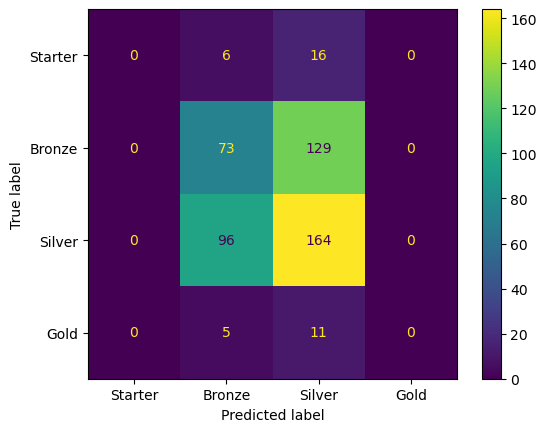

In [37]:
# Mostrar Metriz de Confusão
confusion_matrix_model = confusion_matrix(y,y_pred,labels=lista_segmentos)
disp = ConfusionMatrixDisplay(confusion_matrix_model, display_labels=lista_segmentos)
disp.plot()

## Tuning de Hiperparâmetros

In [38]:
# Ajustar hiperparâmetros do modelo usando Optuna
# min_samples_leaf = mínimo de instâncias requerido para formar uma folha (nó terminal)
# max_depth = Profundidade máxima da árvore

def decision_tree_optuna(trial):
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)

    dt_model.set_params(classifier__min_samples_leaf = min_samples_leaf)
    dt_model.set_params(classifier__max_depth = max_depth)

    scores = cross_val_score(dt_model,X,y,cv=cv_folds,scoring='accuracy')
    return scores.mean()

In [39]:
# Executar a automação de experimentos
estudo_decisiontreee = optuna.create_study(direction='maximize')
estudo_decisiontreee.optimize(decision_tree_optuna,n_trials=100)

[I 2025-10-08 21:50:26,780] A new study created in memory with name: no-name-ef00b2f2-5075-4a71-987e-feb964224cfe
[I 2025-10-08 21:50:26,808] Trial 0 finished with value: 0.46997571122814613 and parameters: {'min_samples_leaf': 17, 'max_depth': 8}. Best is trial 0 with value: 0.46997571122814613.
[I 2025-10-08 21:50:26,845] Trial 1 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 6, 'max_depth': 6}. Best is trial 1 with value: 0.4739917754851743.
[I 2025-10-08 21:50:26,868] Trial 2 finished with value: 0.45398359906692637 and parameters: {'min_samples_leaf': 3, 'max_depth': 4}. Best is trial 1 with value: 0.4739917754851743.
[I 2025-10-08 21:50:26,886] Trial 3 finished with value: 0.4740518962075848 and parameters: {'min_samples_leaf': 1, 'max_depth': 2}. Best is trial 3 with value: 0.4740518962075848.
[I 2025-10-08 21:50:26,903] Trial 4 finished with value: 0.4740518962075848 and parameters: {'min_samples_leaf': 10, 'max_depth': 2}. Best is trial 3 with val

In [40]:
# Mostrar melhor resultado e melhor conjunto de hiperparâmetros
print(f'Melhor Acurácia: {estudo_decisiontreee.best_value}')
print(f'Melhor parâmetros: {estudo_decisiontreee.best_params}')

Melhor Acurácia: 0.4740518962075848
Melhor parâmetros: {'min_samples_leaf': 1, 'max_depth': 2}


## Visualizar Árvore

In [42]:
# Preparar o Conjunto de Dados para Treinar e conseguir visualizar a árvore
X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree.localizacao.astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree.atividade_economica.astype('category').cat.codes
X_train_tree.drop(columns=['localizacao','atividade_economica'], axis=1,inplace=True)
X_train_tree.rename(columns={'localizacao_label':'localizacao','atividade_economica_label':'atividade_economica' },inplace=True)
X_train_tree.head(10)

,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [ ]:
# Treinar o modelo com o conjunto de hiperparâmetros ideal
clf_decision_tree = DecisionTreeClassifier(min_samples_leaf= estudo_decisiontreee.best_params['min_samples_leaf'], 
                                            max_depth=estudo_decisiontreee.best_params['max_depth'])
y_train_tree = y.copy()

clf_decision_tree.fit(X_train_tree,y_train_tree)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 425959.422\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.26\nsamples = 13\nvalue = [2, 0, 0, 11]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.421\nsamples = 152\nvalue = [110, 0, 35, 7]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

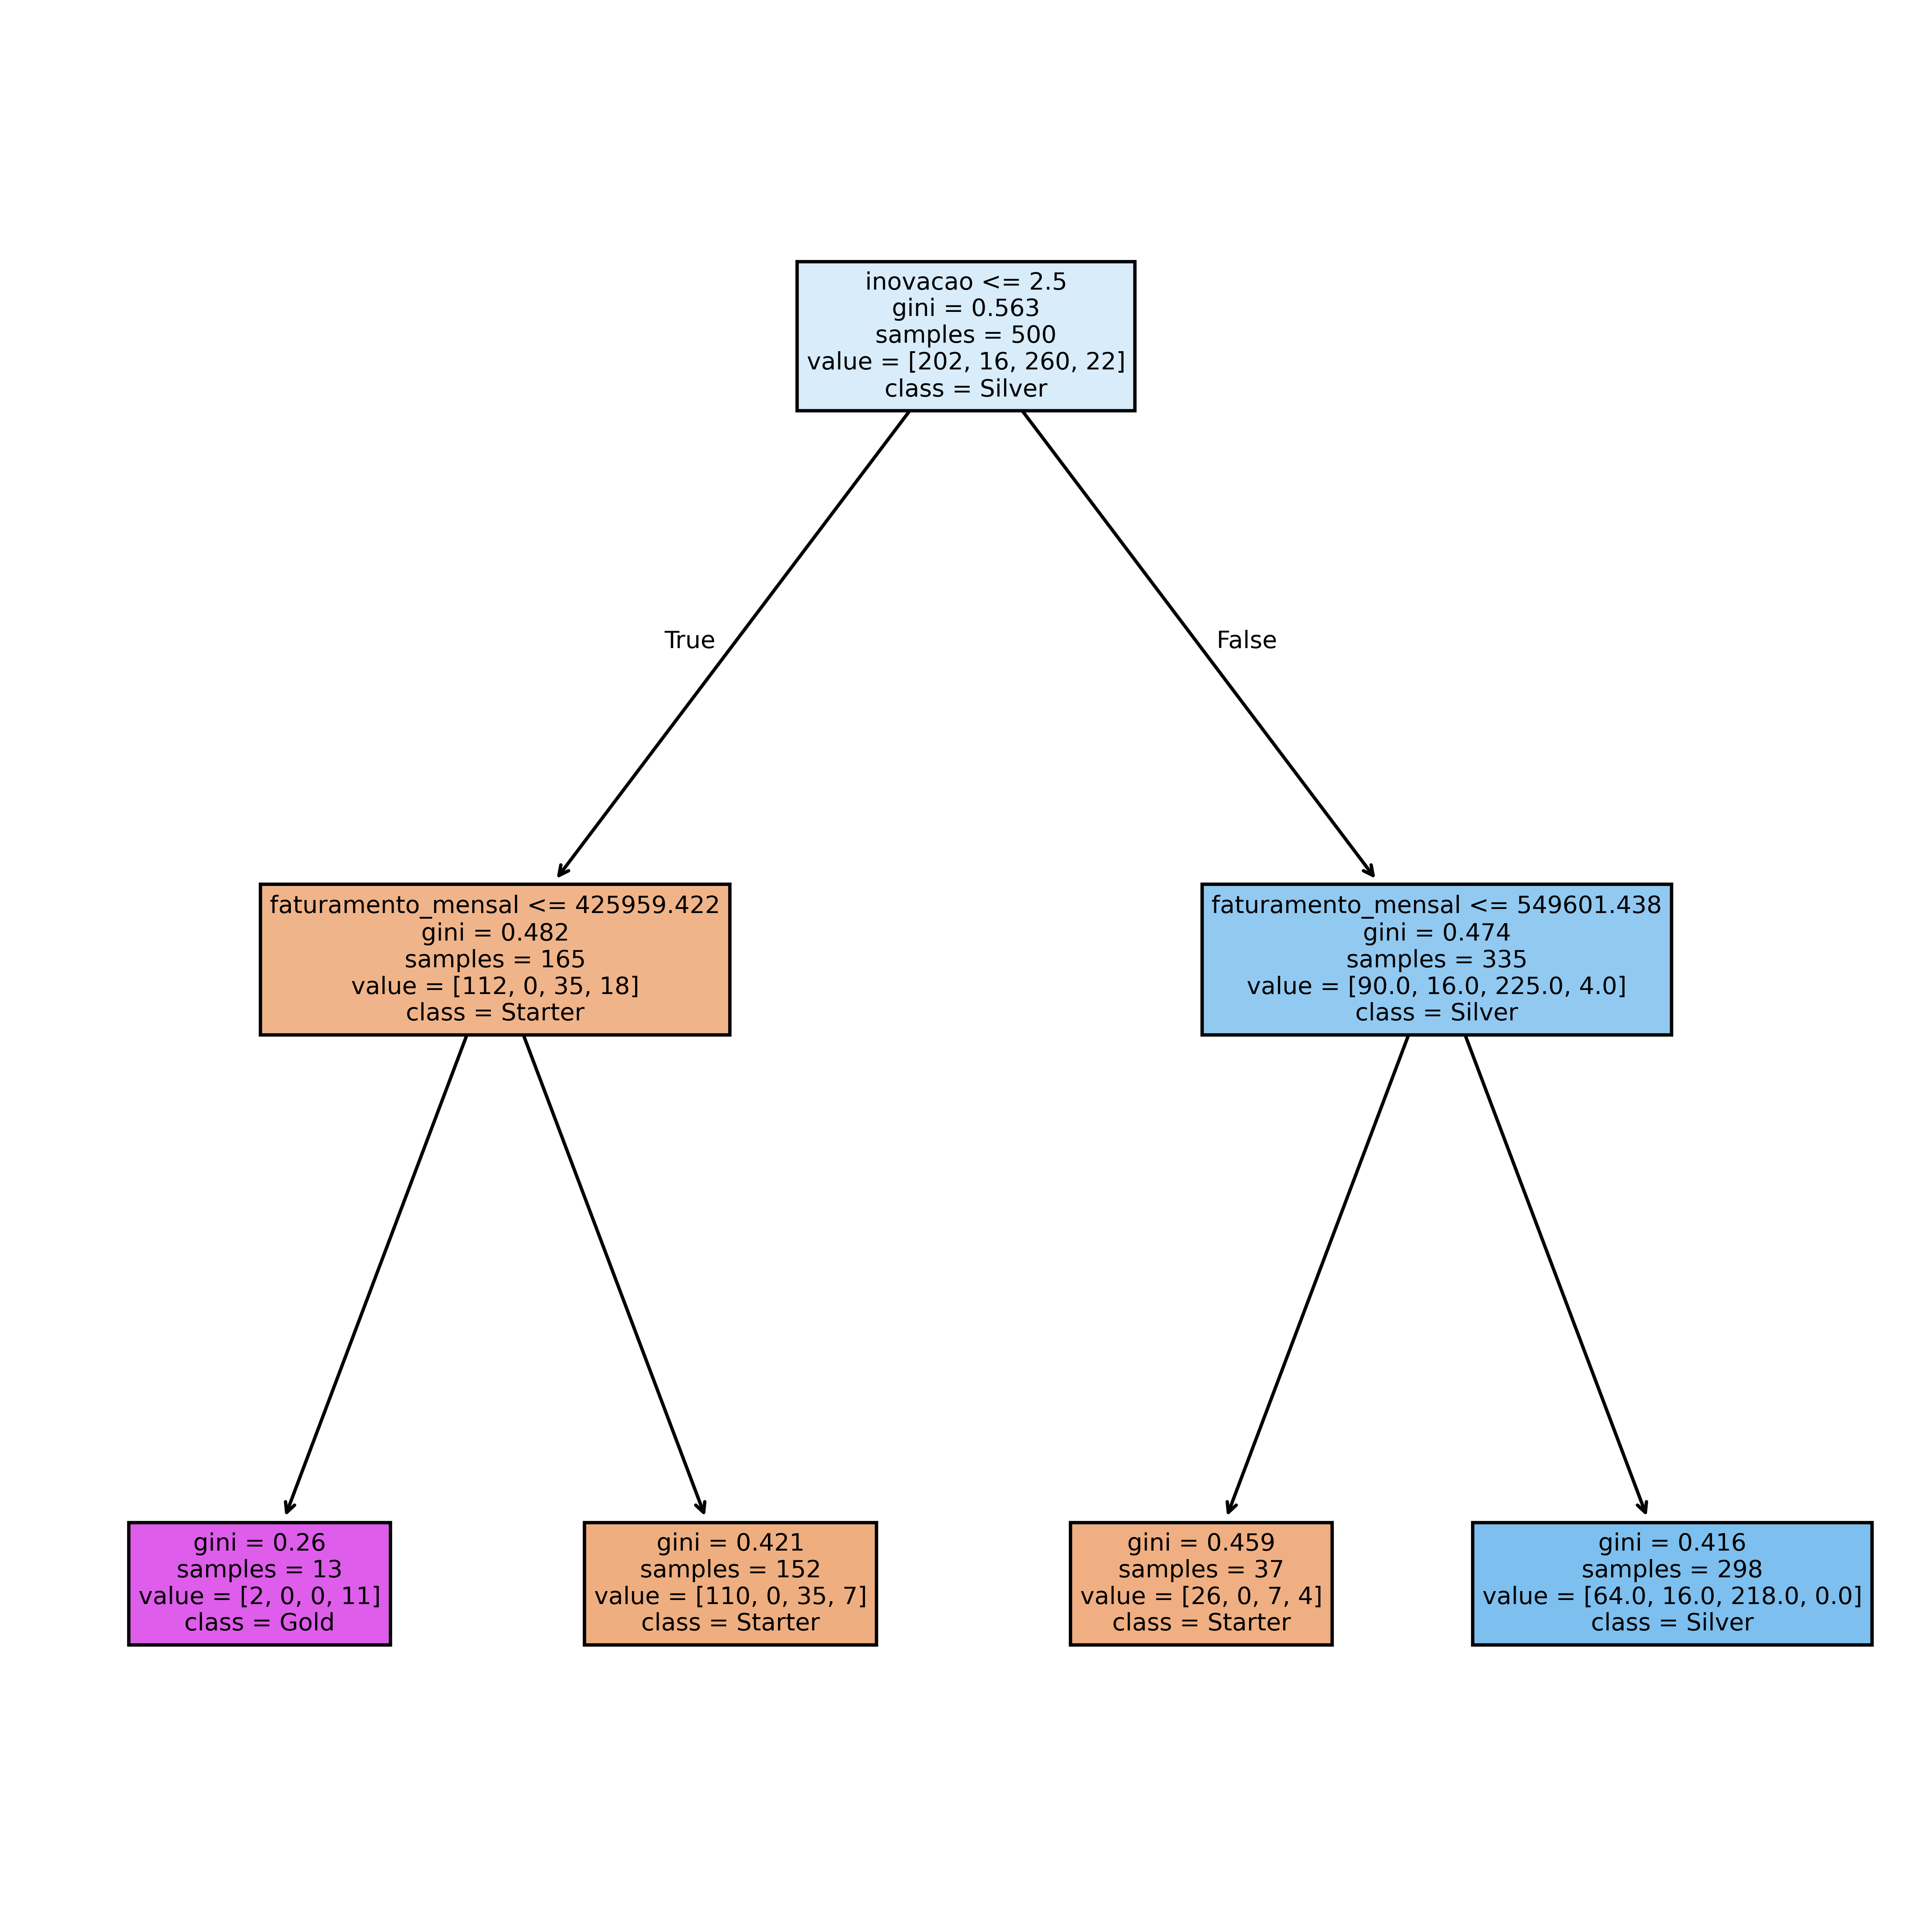

In [ ]:
# Visualizar Árvore de Decisão com Plot Tree
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=600)

plot_tree(clf_decision_tree,
          feature_names=X_train_tree.columns.to_numpy(),
          class_names=lista_segmentos,
          filled=True)

## Salvar o modelo

In [45]:
import joblib

# criar um pipeline "tunado"
dt_model_tunado = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',DecisionTreeClassifier(min_samples_leaf=estudo_decisiontreee.best_params['min_samples_leaf'],
                                         max_depth=estudo_decisiontreee.best_params['max_depth']))
])

# Treinar o modelo tunado
dt_model_tunado.fit(X,y)

# Salvar o modelo
joblib.dump(dt_model_tunado,'modelo_classificacao_decision_tree.pkl')

['modelo_classificacao_decision_tree.pkl']

## Entregar o modelo como App de Predição Batch (por arquivo)

In [47]:
import gradio as gr

modelo = joblib.load("./modelo_classificacao_decision_tree.pkl")

def predict(arquivo):
    df_empresas = pd.read_csv(arquivo.name)
    y_pred = modelo.predict(df_empresas)
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento_de_cliente'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    df_predicoes.to_csv('./predicoes.csv', index=False)

    return './predicoes.csv'

demo = gr.Interface(
    predict,
    gr.File(file_types=[".csv"]),
    "file"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
